> ## ⚠️ Important Lab Disclaimer
> This lab requires API keys (OpenAI, Tavily, OpenWeather) if you want to run the live examples.  
> These keys stay only inside the **temporary Udemy lab workspace** and are **not persisted or shared**, but you should still treat them like any other secret.  
> Use your own discretion when entering keys, and feel free to **revoke or rotate** them after the lab.  
> If you prefer **not** to use real API keys, Copy paste away or download the notebook and run it locally.


This script securely collect API key (`OPENAI_API_KEY`) using `getpass` so your input is hidden.  
It then creates/overwrites a `.env` file and writes each key as `NAME=value` on its own line.  
Finally, it prints **“Saved .env”** when finished.


In [ ]:
from getpass import getpass

names = ["OPENAI_API_KEY"]
with open(".env", "w", encoding="utf-8") as f:
    for n in names:
        f.write(f"{n}={getpass(f'Enter {n}: ').strip()}\n")
print("Saved .env")


This code locates the nearest `.env` file in the current working directory (using `find_dotenv`) and loads its key–value pairs into the environment (using `load_dotenv`).  
It does **not** overwrite any existing environment variables because `override=False`.


In [ ]:
from dotenv import load_dotenv, find_dotenv
env_path = find_dotenv(usecwd=True)
load_dotenv(env_path, override=False)

In [1]:
from typing import Dict, Any, List, Literal
from collections import Counter
import re
import json

from IPython.display import Image, display

from langchain_core.tools import tool
from langchain_core.messages import (
    HumanMessage,
    AIMessage,
    SystemMessage,
    ToolMessage,
    RemoveMessage,
    trim_messages,
)

from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver


In [2]:

chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

Creates a two-message chat history (AI then user) with explicit message IDs for deterministic ordering and tracking.

In [3]:
dialog = [
    AIMessage("Welcome!", id="a1"),
    HumanMessage("Plan for New York.", id="u1"),
]
dialog

[AIMessage(content='Welcome!', additional_kwargs={}, response_metadata={}, id='a1'),
 HumanMessage(content='Plan for New York.', additional_kwargs={}, response_metadata={}, id='u1')]

Replaces the existing user message with the same ID (`u1`) by adding a new HumanMessage, producing an updated chat history.


In [4]:
edited = HumanMessage("Actually, plan for Philly.", id="u1")
updated = add_messages(dialog, edited)  # replaces ID u1 in-place
updated

[AIMessage(content='Welcome!', additional_kwargs={}, response_metadata={}, id='a1'),
 HumanMessage(content='Actually, plan for Philly.', additional_kwargs={}, response_metadata={}, id='u1')]

Removes the message with ID `a1` by passing a `RemoveMessage`, returning the chat history without that entry.


In [5]:
to_delete = [RemoveMessage(id="a1")]
after = add_messages(updated, to_delete)  # removes a1
[m.content for m in after]

['Actually, plan for Philly.']

Sets up two LLMs: `chat` (temperature=0 for stable replies) and `counter` (used only for token counting).  
`trim_example` uses `trim_messages` with `max_tokens=120` and `strategy="last"` to keep only the most recent messages (no partial messages), then calls `chat` on this trimmed window and returns the reply.  
A single-node LangGraph (`budgeted_turn`) is built so every run first trims context, then invokes the model.


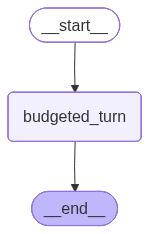

In [6]:
chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
counter = ChatOpenAI(model="gpt-3.5-turbo-0125")  

def trim_example(state: MessagesState):

    window = trim_messages(
        state["messages"],
        max_tokens=120,
        strategy="last",
        token_counter=counter,
        allow_partial=False
    )
    reply = chat.invoke(window)
    return {"messages": [reply]}

g = StateGraph(MessagesState)
g.add_node("budgeted_turn", trim_example)
g.add_edge(START, "budgeted_turn")
g.add_edge("budgeted_turn", END)
app = g.compile()
display(Image(app.get_graph().draw_mermaid_png()))

Creates a full message history capturing a multi-turn physics conversation: system prompt, alternating user questions about Newton’s three laws, and AI explanations. The final user message asks for a concise 5-sentence summary of all laws.


In [7]:

msgs = [
    SystemMessage(content="You are a concise assistant."),
    HumanMessage(content="Explain Newton's First Law in detail."),
    AIMessage(content="Newton's First Law states that an object will remain at rest ..."),
    HumanMessage(content="Now explain Newton's Second Law."),
    AIMessage(content="Newton's Second Law relates force, mass, and acceleration..."),
    HumanMessage(content="Now explain Newton's Third Law."),
    AIMessage(content="Newton's Third Law says every action has an equal and opposite reaction..."),
    HumanMessage(content="Summarize all three laws in under 5 sentences.")
]

Trims the conversation to the last ~50 tokens using `trim_messages` (`strategy="last"` with `counter`), then pretty-prints the final, shortened list of messages that would be sent to the model.

In [8]:
print("=== Final Messages Sent to Model (after trimming) ===")
trimmed = trim_messages(msgs, max_tokens=50, strategy="last", token_counter=counter)
for m in trimmed:
    m.pretty_print()


=== Final Messages Sent to Model (after trimming) ===
================================ Human Message =================================

Now explain Newton's Third Law.
================================== Ai Message ==================================

Newton's Third Law says every action has an equal and opposite reaction...
================================ Human Message =================================

Summarize all three laws in under 5 sentences.


Runs the graph by passing in the full message history; the graph trims the messages and returns the model’s reply as `result`.


In [9]:

result = app.invoke({"messages": msgs})
result


{'messages': [SystemMessage(content='You are a concise assistant.', additional_kwargs={}, response_metadata={}, id='6c758579-0d9b-4bd9-9d9e-9ce3003dc178'),
  HumanMessage(content="Explain Newton's First Law in detail.", additional_kwargs={}, response_metadata={}, id='36bc7d41-8462-49a6-adc3-dbd767534f83'),
  AIMessage(content="Newton's First Law states that an object will remain at rest ...", additional_kwargs={}, response_metadata={}, id='01301209-46a8-4dd0-9648-d4535ff95086'),
  HumanMessage(content="Now explain Newton's Second Law.", additional_kwargs={}, response_metadata={}, id='5c9dfda8-e84e-4eab-ad2e-14d3cb1414d2'),
  AIMessage(content="Newton's Second Law relates force, mass, and acceleration...", additional_kwargs={}, response_metadata={}, id='bca96270-dca8-4125-a1db-5f9049bb93ab'),
  HumanMessage(content="Now explain Newton's Third Law.", additional_kwargs={}, response_metadata={}, id='0538a831-c0da-43ab-8bd4-153bfe009676'),
  AIMessage(content="Newton's Third Law says every 

Defines a `TravelState` that extends `MessagesState` with a rolling text synopsis `memo`.  
`chat_turn` optionally prepends a system message (`Trip recap: {memo}`) before calling `chat`, so each reply is conditioned on the running recap.  
`tighten_summary` asks the model to either create or extend the recap from the latest turns, saves that text into `memo`, and returns `RemoveMessage` objects to drop older messages (keeping only the freshest ones).  
`should_summarize` routes to `tighten_summary` once the message list grows beyond 6 turns; otherwise the flow ends.  
A two-node LangGraph (`chat_turn` → optional `tighten_summary`) is compiled with `MemorySaver`, so `memo` and trimmed messages persist across runs.


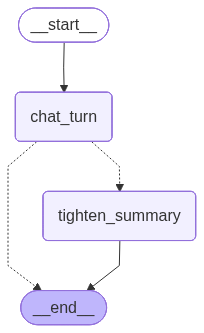

In [10]:

class TravelState(MessagesState):
    memo: str  # rolling synopsis

def chat_turn(state: TravelState):
    memo = state.get("memo","")
    msgs = ([SystemMessage(content=f"Trip recap: {memo}")] + state["messages"]) if memo else state["messages"]
    out = chat.invoke(msgs)
    return {"messages":[out]}

def tighten_summary(state: TravelState):
    memo = state.get("memo","")
    ask = "Extend the recap using ONLY the new turns above." if memo else "Summarize the chat above in 3 bullets."
    msgs = state["messages"] + [HumanMessage(content=ask)]
    out = chat.invoke(msgs)
    drops = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"memo": out.content, "messages": drops}

from typing import Literal
def should_summarize(state: TravelState) -> Literal["tighten_summary", END]:
    return "tighten_summary" if len(state["messages"]) > 6 else END    

flow = StateGraph(TravelState)
flow.add_node("chat_turn", chat_turn); flow.add_node("tighten_summary", tighten_summary)
flow.add_edge(START,"chat_turn")
flow.add_conditional_edges("chat_turn", should_summarize)
flow.add_edge("tighten_summary", END)

store = MemorySaver()
summ_graph = flow.compile(checkpointer=store)
display(Image(summ_graph.get_graph().draw_mermaid_png()))

Defines a config dict with a `thread_id` (`"nyc-trip-1"`) for per-thread LangGraph memory.  
`show_last` is a small helper that safely pretty-prints only the last message in a reply, if any messages exist.


In [11]:
cfg = {"configurable": {"thread_id": "nyc-trip-1"}}

def show_last(reply):
    msgs = reply.get("messages", [])
    if msgs:  # guard for empty history
        msgs[-1].pretty_print()

Runs the summary graph for the first turn, starting a new thread (`thread_id="nyc-trip-1"`) with a single human message about a 2-night NYC family trip, then prints only the model’s latest reply.


In [12]:
# Turn 1
out = summ_graph.invoke({"messages": [HumanMessage(content="We’re a family of 4 visiting New York for 2 nights.")]}, cfg)
show_last(out)

================================== Ai Message ==================================

That's great! New York City has so much to offer for families. Are you looking for any specific recommendations or tips for your visit?


Invokes the graph again in the same thread, adding the new human message about Times Square and a mid-range budget, and then prints the latest model reply.


In [13]:
# Turn 2
out = summ_graph.invoke({"messages": [HumanMessage(content="We’ll stay near Times Square. Budget is mid-range.")]}, cfg)
show_last(out)

================================== Ai Message ==================================

That's a great location for exploring the city! Here are some recommendations for your visit:

1. Visit Times Square: Take a stroll through the iconic Times Square, known for its bright lights, Broadway theaters, and bustling atmosphere.

2. Central Park: Spend some time in Central Park, a peaceful oasis in the middle of the city. You can rent bikes, have a picnic, or visit the Central Park Zoo.

3. Empire State Building: Take a trip to the top of the Empire State Building for stunning views of the city skyline.

4. Statue of Liberty: Take a ferry to visit the Statue of Liberty and Ellis Island. Be sure to book your tickets in advance.

5. Museum of Modern Art (MoMA): Explore one of the world's most famous modern art museums, located near Times Square.

6. Broadway Show: Catch a family-friendly Broadway show in the Theater District. You can often find discounted tickets at the TKTS booth in Times Square.


Runs the next turn with the user’s Day-1 request (Central Park + kid-friendly museum), updates the rolling recap via the graph, and prints the newest model reply.


In [14]:
# Turn 3
out = summ_graph.invoke({"messages": [HumanMessage(content="Day 1 afternoon: we’d like Central Park and a kid-friendly museum.")]}, cfg)
show_last(out)

================================== Ai Message ==================================

That sounds like a great plan for your first afternoon in New York City! Here's a suggested itinerary for Day 1:

Afternoon:
1. Central Park: Start your afternoon with a visit to Central Park. You can rent bikes or take a leisurely stroll through the park. Be sure to check out popular spots like Bethesda Terrace, Bow Bridge, and the Central Park Zoo.

2. American Museum of Natural History: This kid-friendly museum is located near Central Park and offers a wide range of exhibits on natural history, dinosaurs, and more. Kids will love the interactive displays and hands-on activities.

3. After exploring Central Park and the museum, you can grab dinner at one of the many family-friendly restaurants in the area or head back to Times Square for a meal.

Enjoy your afternoon exploring Central Park and the museum!


Sends a fourth turn in the same thread asking for a rainy-day indoor backup plan; the graph updates the memo/summary as needed and then `show_last` prints just the latest AI reply.


In [ ]:
# Turn 4
out = summ_graph.invoke({"messages": [HumanMessage(content="Suggest an indoor backup if it rains.")]}, cfg)
show_last(out)

Processes a fifth turn asking for casual dinner ideas near Rockefeller Center; the graph incorporates this into the running summary (if the threshold is hit) and `show_last` prints only the newest AI response.


In [15]:
# Turn 5
out = summ_graph.invoke({"messages": [HumanMessage(content="Dinner ideas near Rockefeller Center, casual.")]}, cfg)
show_last(out)

================================== Ai Message ==================================

There are plenty of casual dining options near Rockefeller Center that are perfect for families. Here are some recommendations for dinner:

1. Shake Shack: Located on 8th Avenue, Shake Shack is a popular spot for burgers, fries, and shakes. It's a casual and family-friendly option.

2. Bill's Bar & Burger: This casual burger joint on West 51st Street offers a variety of burgers, sandwiches, and milkshakes in a relaxed atmosphere.

3. The Halal Guys: If you're in the mood for some delicious street food, head to The Halal Guys on 53rd Street for their famous chicken and gyro platters.

4. Junior's Restaurant: Known for their classic New York cheesecake, Junior's on West 45th Street also serves up comfort food favorites like burgers, sandwiches, and salads.

5. Szechuan Gourmet: If you're in the mood for Chinese cuisine, Szechuan Gourmet on West 39th Street offers a variety of Szechuan dishes in a casual set

Runs a sixth turn with Day-2 plans (Statue of Liberty + SoHo shopping). The graph may trigger a recap update based on message count, and `show_last` displays the latest AI reply.


In [16]:
# Turn 6
out = summ_graph.invoke({"messages": [HumanMessage(content="Day 2: Statue of Liberty in the morning, then SoHo shopping.")]}, cfg)
show_last(out)

================================== Ai Message ==================================

For your Day 2 itinerary of visiting the Statue of Liberty in the morning and then heading to SoHo for shopping, here's a suggested plan:

Morning:
1. Statue of Liberty: Start your day early and head to Battery Park to catch the ferry to the Statue of Liberty. Make sure to book your tickets in advance to avoid long lines. Enjoy the scenic ferry ride and explore Liberty Island and the Statue of Liberty.

Afternoon:
2. SoHo Shopping: After your visit to the Statue of Liberty, take a ferry back to Manhattan and make your way to SoHo for some shopping. SoHo is known for its trendy boutiques, designer stores, and unique shops. Spend the afternoon exploring the cobblestone streets and browsing the various shops.

Lunch:
For lunch, you can grab a bite to eat at one of the many cafes or restaurants in SoHo. Some popular options include Jack's Wife Freda, Balthazar, or The Butcher's Daughter for a delicious meal.


Sends a seventh turn (“skyline view at night”), which exceeds the >6 message threshold and triggers `tighten_summary`; the graph updates the memo and prunes older messages, and `show_last` prints the fresh AI reply.


In [17]:
# Turn 7 (this should cross your >6 threshold and trigger tighten_summary)
out = summ_graph.invoke({"messages": [HumanMessage(content="End with a skyline view at night.")]}, cfg)
show_last(out)


================================== Ai Message ==================================

To end your Day 2 in New York City with a stunning skyline view at night, I recommend heading to one of the following locations for a memorable experience:

1. Top of the Rock Observation Deck: Located at Rockefeller Center, Top of the Rock offers panoramic views of the city skyline, including the Empire State Building and Central Park. It's a great spot to see the city lights at night.

2. One World Observatory: Situated at One World Trade Center, the One World Observatory provides breathtaking views of Manhattan and beyond. You can enjoy the city's twinkling lights from the tallest building in the Western Hemisphere.

3. Brooklyn Bridge Park: For a different perspective of the skyline, head to Brooklyn Bridge Park. You can walk along the waterfront promenade and enjoy stunning views of the Manhattan skyline, including the iconic Brooklyn Bridge and Lower Manhattan.

4. The High Line: The High Line is an

Reads the graph’s persisted state for this thread and prints the `memo` value, showing the latest rolling trip recap produced by `tighten_summary`.


In [18]:
# Inspect the rolling memo created by tighten_summary
memo = summ_graph.get_state(cfg).values.get("memo", "")
print("\n--- Trip Recap Memo (NYC) ---\n", memo)



--- Trip Recap Memo (NYC) ---
 - Family of 4 visiting New York for 2 nights, staying near Times Square with a mid-range budget
- Day 1 afternoon plan includes visiting Central Park and a kid-friendly museum like the American Museum of Natural History
- Dinner options near Rockefeller Center for a casual meal include Shake Shack, Bill's Bar & Burger, The Halal Guys, Junior's Restaurant, and Szechuan Gourmet


Continues the conversation in the same thread; the graph auto-injects the stored `memo` as a SystemMessage before the model call, and `show_last` prints the newest itinerary-focused reply.


In [19]:

# Keep chatting: memo is injected as a SystemMessage automatically
out = summ_graph.invoke({"messages": [HumanMessage(
    content="Now build a 2-day itinerary with time blocks, walk times, and indoor backups."
)]}, cfg)
show_last(out)


================================== Ai Message ==================================

Day 1:

Morning:
- 8:00 AM: Breakfast at a nearby cafe or diner
- 9:00 AM: Walk to Central Park (approx. 15-20 minutes)
- 9:30 AM - 12:30 PM: Explore Central Park, visit playgrounds, rent bikes, or take a boat ride
Backup: If it's raining, visit the American Museum of Natural History

Lunch:
- 12:30 PM: Grab lunch at a nearby cafe or food vendor in Central Park

Afternoon:
- 1:30 PM: Walk to the American Museum of Natural History (approx. 15-20 minutes)
- 2:00 PM - 5:00 PM: Explore the museum's exhibits and interactive displays
Backup: If time allows, visit the nearby Children's Museum of Manhattan

Dinner:
- 6:00 PM: Head to Rockefeller Center for dinner
- Choose from casual options like Shake Shack, Bill's Bar & Burger, The Halal Guys, Junior's Restaurant, or Szechuan Gourmet

Day 2:

Morning:
- 8:00 AM: Breakfast at the hotel or a nearby cafe
- 9:00 AM: Walk to Battery Park (approx. 20-25 minutes)
- 9: